# AIVLE스쿨 2차 미니프로젝트: 신규 아파트 주차 수요 예측

<img src = "https://github.com/Jangrae/img/blob/master/parking.png?raw=true" width=800, align="left"/>

# 단계 3: 회귀모델 모델링

## [미션]

- 모델링을 수행합니다.
    - 전처리를 추가로 진행합니다.
    - 4개 이상의 알고리즘을 사용해 모델링을 수행합니다.
    - 각 모델에 대해 성능 튜닝을 수행합니다.
    - 성능을 비교해 최선의 모델을 선정합니다.
- 데이터 파이프라인 함수를 만듭니다.
- 새로운 데이터를 읽어와 예측을 수행합니다.

## 1. 환경설정

### (1) 로컬 수행(Anaconda)

- project 폴더에 필요한 파일들을 넣고, 본 파일을 열었다면, 별도 경로 지정이 필요하지 않습니다.

In [88]:
# 기본 경로
path = ''

### (2) 구글 콜랩 수행

- 구글 콜랩을 사용중이면 구글 드라이브를 연결합니다.

In [90]:
# 구글 드라이브 연결, 패스 지정
# import sys
# if 'google.colab' in sys.modules:
#     from google.colab import drive
#     drive.mount('/content/drive')
#     path = '/content/drive/MyDrive/project/'

### (3) 한글 폰트 표시용 라이브러리 설치

In [92]:
# 한글 표시를 위한 라이브러리 설치
# !pip install koreanize_matplotlib -q
# !pip install xgboost
# !pip install lightgbm -q


### (4) 라이브러리 불러오기

In [210]:
# 기본 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 모델링용 라이브러리 불러오기
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor 
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier, XGBRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler


# 기타 라이브러리 불러기기
import joblib
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (5) 데이터 불러오기

- joblib.dump() 함수를 사용해 base_data2.pkl 파일을 읽어옵니다.
- 읽어온 데이터를 data 데이터프레임으로 선언하고 기본 정보를 확인합니다.

In [96]:
# 파일 읽어오기
data = joblib.load(path+'base_data2.pkl')
data_region = joblib.load(path+'base_data2_region.pkl')
# 확인
data.head()

,총세대수,준공연도,건물형태,난방방식,승강기설치여부,실차량수,총면적,면적10_30,면적30_40,면적40_50,면적50_60,면적60_70,면적70_80,면적80_200,임대보증금,임대료
0,78,2013,계단식,개별,1,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000
1,35,2013,복도식,개별,1,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000
2,88,2013,계단식,개별,1,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000
3,477,2014,복도식,지역,1,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000
4,15,2013,복도식,개별,1,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333


In [97]:
data_region.head()


,총세대수,지역,준공연도,건물형태,난방방식,승강기설치여부,실차량수,총면적,면적10_30,면적30_40,면적40_50,면적50_60,면적60_70,면적70_80,면적80_200,임대보증금,임대료
0,78,서울,2013,계단식,개별,1,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000
1,35,서울,2013,복도식,개별,1,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000
2,88,서울,2013,계단식,개별,1,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000
3,477,서울,2014,복도식,지역,1,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000
4,15,서울,2013,복도식,개별,1,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333


### (6) 함수 생성

- 실젯값과 모델이 예측한 값을 시각화해 비교할 함수를 만듭니다.

In [99]:
# 실젯값, 예측값 비교 함수 만들기
def model_plot(y_test, y_pred):
    plt.figure(figsize=(10, 3))
    plt.plot(y_test.values, label='Actual', linewidth=0.7, marker='o', markersize=2)
    plt.plot(y_pred, label='Predicted', linewidth=0.7, marker='o', markersize=2)
    plt.legend()
    plt.show()

## 2. 모델링

- 모델링을 위한 결측치 처리, 데이터 분할, 스케일링, 가변수화 등을 수행합니다.
- 4개 이상의 알고리즘을 사용하여 모델을 만듭니다.
- 모델 이름은 서로 다르게 합니다. (예: model1, model2...)
- Linear Regression 이외의 알고리즘을 사용한 모델은 GridSearchCV() 함수로 성능 최적화를 수행합니다.
- 적절한 평가지표로 모델의 성능을 평가합니다.
- 실젯값과 예측값을 시각화해 비교합니다.
- 성능 비교를 통해 최선의 모델을 선정합니다.

### (1) 데이터 전처리

- 필요한 전처리를 수행합니다.

#### 1) 가변수화

- '건물형태', '난방방식' 변수에 대해 가변수화를 수행합니다.

In [103]:
# 가변수화
dumm_cols = ['건물형태', '난방방식']

# 가변수화
data = pd.get_dummies(data, columns=dumm_cols, drop_first=True, dtype=int)

# 확인
data.head()


,총세대수,준공연도,승강기설치여부,실차량수,총면적,면적10_30,면적30_40,면적40_50,면적50_60,면적60_70,면적70_80,면적80_200,임대보증금,임대료,건물형태_복도식,건물형태_혼합식,난방방식_중앙,난방방식_지역
0,78,2013,1,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000,0,0,0,0
1,35,2013,1,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000,1,0,0,0
2,88,2013,1,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000,0,0,0,0
3,477,2014,1,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000,1,0,0,1
4,15,2013,1,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333,1,0,0,0


#### 2) x, y 분리

- Target를 지정하고, x와 y로 분리합니다.

In [105]:
target = '실차량수'

# 데이터 분리
x = data.drop(target, axis=1)
y = data.loc[:, target]

#### 3) 학습용, 평가용 분리

- 학습용, 평가용 데이터를 적절한 비율로 분리합니다.

In [107]:
# 모듈 불러오기
from sklearn.model_selection import train_test_split

# 기존의 test를 value로 변경
# 7:3으로 분리
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=1)


#### 4) 스케일링

- 필요한 경우 스케일링을 진행합니다.
- 예를 들어 KNN 알고리즘을 사용할 경우입니다.

### (2) 모델 1:LinearRegression 알고리즘

In [214]:
linear_model = LinearRegression()
linear_model.fit(x_train, y_train)
y_pred = linear_model.predict(x_val)
print('MAE : ',mean_absolute_error(y_val, y_pred))
print('R2-Score: ', r2_score(y_val, y_pred))
linear_MAE = mean_absolute_error(y_val, y_pred)
linear_R2 =  r2_score(y_val, y_pred)

MAE :  149.3624475279191
R2-Score:  0.6552971905240368


In [212]:
# Linear Regression (Ridge Regression)
# 하이퍼파라미터 범위 설정
ridge_param = {'alpha': [0.1, 1, 10, 100]}  # 정규화 강도 조절

# GridSearchCV로 모델 생성 및 학습
ridge_model = GridSearchCV(Ridge(), ridge_param, cv=5)  # 5-fold 교차 검증
ridge_model.fit(x_train, y_train)

# 최적 모델 선택
ridge_best = ridge_model.best_estimator_

# 검증 데이터 예측
y_pred = ridge_best.predict(x_val)

# 성능 평가
ridge_MAE = mean_absolute_error(y_val, y_pred)
ridge_R2 = r2_score(y_val, y_pred)

print(ridge_MAE, ridge_R2)

149.38675460196492 0.6551615150035046


### (3) 모델 2: DecisionTree 알고리즘


In [176]:
param = {'max_depth': range(1, 21)}
decision_model = GridSearchCV(DecisionTreeRegressor(),param, cv=5)
decision_model.fit(x_train, y_train)
y_val_pred = decision_model.predict(x_val)
print("Best parameters found: ", decision_model.best_params_)
print("Best cross-validation score: ", decision_model.best_score_)
print('MAE:', mean_absolute_error(y_val, y_val_pred))
print('R2:', r2_score(y_val, y_val_pred))
decision_MAE = mean_absolute_error(y_val, y_val_pred)
decision_R2 = r2_score(y_val, y_val_pred)

Best parameters found:  {'max_depth': 3}
Best cross-validation score:  0.6687860015428747
MAE: 171.2319847605225
R2: 0.6219762284733569


In [220]:
# Decision 파라미터 추가
# 하이퍼파라미터 범위 설정
decision_param = {
    'max_depth': range(1, 21),  # 최대 깊이
    'min_samples_split': [2, 5, 10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]  # 리프 노드에 필요한 최소 샘플 수
}

# GridSearchCV로 모델 생성 및 학습
decision_model = GridSearchCV(DecisionTreeRegressor(), decision_param, cv=5)
decision_model.fit(x_train, y_train)

# 최적 모델 선택
decision_best = decision_model.best_estimator_

# 검증 데이터 예측
y_val_pred = decision_best.predict(x_val)

# 성능 평가
decision2_MAE = mean_absolute_error(y_val, y_val_pred)
decision2_R2 = r2_score(y_val, y_val_pred)
print("Best parameters found: ", decision_model.best_params_)
print("Best cross-validation score: ", decision_model.best_score_)
print(decision2_MAE, decision2_R2)

Best parameters found:  {'max_depth': 9, 'min_samples_leaf': 4, 'min_samples_split': 10}
Best cross-validation score:  0.6808845356810007
153.24641712454212 0.6242660311623938


### (4) 모델 3: RandomForestRegressor 알고리즘

In [178]:
param = {'max_depth': range(1, 21)}
random_model = GridSearchCV(RandomForestRegressor(),param, cv=5)
random_model.fit(x_train, y_train)
y_val_pred = random_model.predict(x_val)
print("Best parameters found: ", random_model.best_params_)
print("Best cross-validation score: ", random_model.best_score_)
print('MAE:', mean_absolute_error(y_val, y_val_pred))
print('R2:', r2_score(y_val, y_val_pred))
random_MAE = mean_absolute_error(y_val, y_val_pred)
random_R2 = r2_score(y_val, y_val_pred)

Best parameters found:  {'max_depth': 16}
Best cross-validation score:  0.763954224745331
MAE: 130.7839423076923
R2: 0.6834777378171336


In [288]:
# 파라미터 설정
# 하이퍼파라미터 범위 설정
random_param = {
    'n_estimators': [50, 100, 200],  # 생성할 트리의 수
    'max_depth': [5, 10, 15],  # 최대 깊이
    'min_samples_split': [2, 5, 10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]  # 리프 노드에 필요한 최소 샘플 수
}

# GridSearchCV로 모델 생성 및 학습
random_model = GridSearchCV(RandomForestRegressor(), random_param, cv=5)
random_model.fit(x_train, y_train)

# 최적 모델 선택
random_best = random_model.best_estimator_

# 검증 데이터 예측
y_val_pred = random_best.predict(x_val)

# 성능 평가
print("Best parameters found: ", random_model.best_params_)
print("Best cross-validation score: ", random_model.best_score_)
print('MAE:', mean_absolute_error(y_val, y_val_pred))
print('R2:', r2_score(y_val, y_val_pred))
random2_MAE = mean_absolute_error(y_val, y_val_pred)
random2_R2 = r2_score(y_val, y_val_pred)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- 난방방식_중앙
- 난방방식_지역
- 승강기설치여부


### (5) 모델 4:  LGBMRegressor 알고리즘

In [180]:
# 파라미터 선언
param = {'max_depth': range(1, 21)}
lgbm_model = GridSearchCV(LGBMRegressor(verbose=1),param, cv=5)
# model = LGBMClassifier()

# 학습하기
lgbm_model.fit(x_train, y_train)

# 예측하기
y_pred = lgbm_model.predict(x_val)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 411
[LightGBM] [Info] Number of data points in the train set: 192, number of used features: 14
[LightGBM] [Info] Start training from score 575.109375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

In [182]:
# 평가하기
print("Best parameters found: ", lgbm_model.best_params_)
print("Best cross-validation score: ", lgbm_model.best_score_) 
lgbm_MAE = mean_absolute_error(y_val, y_val_pred)
lgbm_R2 = r2_score(y_val, y_val_pred)
lgbm_best_params = lgbm_model.best_params_
lgbm_best_score = lgbm_model.best_score_

Best parameters found:  {'max_depth': 2}
Best cross-validation score:  0.7462778686736506


### (6) 모델 5: XGB 알고리즘

In [184]:
# 선언하기
xgb_model = XGBRegressor()

# 학습하기
xgb_model.fit(x_train, y_train)

# 예측하기
y_pred = xgb_model.predict(x_val)

# 평가하기
print('MAE: ', mean_absolute_error(y_val, y_pred).round(4))
print('R2_Score: ', r2_score(y_val, y_pred))
xgb_MAE = mean_absolute_error(y_val, y_pred)
xgb_R2 = r2_score(y_val, y_pred)

MAE:  129.0327
R2_Score:  0.6925180586016446


### (7) 모델 6: KNN 알고리즘

In [196]:

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_s = scaler.transform(x_train)
x_val_s = scaler.transform(x_val)

In [206]:
# KNeighborsRegressor
params = {
    'n_neighbors' : range(3, 16)
}
 
knn_model = GridSearchCV(KNeighborsRegressor(), params, cv=5)
knn_model.fit(x_train_s, y_train)
y_pred = knn_model.predict(x_val_s)

knn_MAE = mean_absolute_error(y_val, y_pred)
knn_R2 = r2_score(y_val, y_pred)
knn_best_param = knn_model.best_params_
knn_best_score = knn_model.best_score_
print(knn_model.cv_results_['mean_test_score'])
print('최적파라미터:', knn_model.best_params_)
print('최고성능:', knn_model.best_score_)
print(knn_MAE, knn_R2)

[0.65548074 0.67613719 0.67379013 0.65992641 0.65890396 0.64627826
 0.63775709 0.62479917 0.60673723 0.59507278 0.58449626 0.56648423
 0.5523294 ]
최적파라미터: {'n_neighbors': 4}
최고성능: 0.6761371915901122
164.60096153846155 0.6129804776167364


### (8) 모델 7: 알고리즘

### (9) 모델 8: 알고리즘

### (7) 성능 비교

- 각 모델의 성능을 비교합니다.

In [188]:
# 데이터프레임 생성
results = {
    '모델': ['Linear Regression', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGBoost'],
    'MAE': [linear_MAE, decision_MAE, random_MAE, lgbm_MAE, xgb_MAE],
    'R²': [linear_R2, decision_R2, random_R2, lgbm_R2, xgb_R2]
}

results_df = pd.DataFrame(results)

# 예쁘게 출력
print("모델 성능 지표")
results_df


모델 성능 지표


,모델,MAE,R²
0,Linear Regression,149.362448,0.655297
1,Decision Tree,171.231985,0.621976
2,Random Forest,130.783942,0.683478
3,LightGBM,130.783942,0.683478
4,XGBoost,129.032665,0.692518


## 3. 파이프라인 구축

- 새로운 데이터를 불러오고, 이 데이터를 처리할 파이프라인 함수를 만듭니다.

### (1) New Data 불러오기

- test.xlsx 파일을 읽어와 new_data 데이터프레임으로 선언합니다.
- 해당 데이터는 '실차량수' 변수가 없는 것 외에는, 최초 데이터와 동일한 구조입니다.
- 이 데이터를 대상으로 전처리와 예측을 수행합니다.

In [307]:
# 파일 읽어오기
new_data = pd.read_excel(path+'test.xlsx')
first_data = pd.read_excel(path+'train.xlsx')

# 확인
new_data.head()

,단지코드,단지명,총세대수,전용면적별세대수,지역,준공일자,건물형태,난방방식,승강기설치여부,단지내주차면수,전용면적,공용면적,임대보증금,임대료
0,C0005,서울석촌 도시형주택(공임10년),20,6,서울,20121115,복도식,개별가스난방,전체동 설치,9,17.53,11.7251,50449000,263710
1,C0005,서울석촌 도시형주택(공임10년),20,10,서울,20121115,복도식,개별가스난방,전체동 설치,9,24.71,16.5275,52743000,321040
2,C0005,서울석촌 도시형주택(공임10년),20,4,서울,20121115,복도식,개별가스난방,전체동 설치,9,26.72,17.8720,53890000,332510
3,C0017,대구혁신센텀힐즈,822,228,대구경북,20180221,계단식,지역난방,NaN,824,51.87,20.9266,29298000,411200
4,C0017,대구혁신센텀힐즈,822,56,대구경북,20180221,계단식,지역난방,NaN,824,59.85,24.1461,38550000,462600


### (2) 데이터 파이프라인 구축

- 데이터 파이프라인 함수를 만듭니다.
- 학습 데이터에 대해 진행했던 모든 전처리 과정을 평가 데이터에도 일괄 진행해야 합니다.
    - 입력: new_data
    - 출력: 전처리가 완료된 예측 직전 데이터프레임
- 새로운 데이터에는 '실차량수' 변수가 없음을 유의합니다.
- 참고: 다음 내용들이 처리되어야 합니다.
    - 결측치 처리
    - 변수 추가
    - 불필요한 변수 제거
    - 단지 데이터, 상세 데이터 분리
    - 단지코드별 총면적 합 집계
    - 전용면적 구간별 집계 (피벗 형태)
    - 임대보증금, 임대료 평균 집계
    - 집계 결과 병합
    - 난방방식: 개별, 지역, 중앙 세 가지로 묶기
    - 승강기설치여부: 0, 1 값으로 변경
    - 변수 제거
        - 단지모드, 지역 변수 제거 >> 1안
        - 단지모드만 제거 >> 2안
    - 가변수화

In [223]:
# 파이프라인 만들기
# def data_pipeline(data):
#     apt01 = data.copy()

    

In [309]:
# 파이프라인 만들기
# 파이프라인 만들기
def data_pipeline(data, is_train=False):
    apt01 = data.copy()
 
    # 결측치 최빈값 처리
    process_list = ('건물형태', '난방방식', '승강기설치여부')
    for column in process_list:
        apt01[column].fillna(apt01[column].mode()[0], inplace=True)
 
    # 준공연도 뽑아내기
    apt01['준공연도'] = apt01['준공일자'] // 10000
 
    # 총면적 계산
    apt01['총면적'] = (apt01['전용면적'] + apt01['공용면적']) * apt01['전용면적별세대수']
 
    # 불필요 데이터 드랍
    apt01.drop(columns=['단지명', '단지내주차면수', '준공일자'], inplace=True)
 
    # 단지별 데이터 분리
    if is_train is True:
        data01 = apt01.loc[:, ['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부', '실차량수']]
    else:
        data01 = apt01.loc[:, ['단지코드', '총세대수', '지역', '준공연도', '건물형태', '난방방식', '승강기설치여부']]
    data01.drop_duplicates(inplace=True)
    data01.reset_index(drop=True, inplace=True)
 
    # 상세 데이터 분리
    data02 = apt01.loc[:, ['단지코드', '총면적', '전용면적별세대수', '전용면적', '공용면적', '임대보증금', '임대료']]
    data02['전용면적구간'] = pd.cut(data02['전용면적'], bins=[10, 30, 40, 50, 60, 70, 80, 200], labels=['면적10_30', '면적30_40', '면적40_50', '면적50_60', '면적60_70', '면적70_80', '면적80_200'])
 
    df_area = data02.groupby(by='단지코드', as_index=False)[['총면적']].sum()
 
    df_pivot = data02.groupby(by=['단지코드', '전용면적구간'], as_index=False)[['전용면적별세대수']].sum()
    df_pivot = df_pivot.pivot(index='단지코드', columns='전용면적구간', values='전용면적별세대수')
    df_pivot.columns.name = None
    df_pivot.reset_index(inplace=True)
 
    df_rent = data02.groupby(by='단지코드', as_index=False)[['임대보증금', '임대료']].mean()
 
    apt01 = data01.merge(df_area, how='left', on='단지코드')
    apt01 = apt01.merge(df_pivot, how='left', on='단지코드')
    apt01 = apt01.merge(df_rent, how='left', on='단지코드')
 
    # 추가 전처리
    apt01['난방방식'] = apt01['난방방식'].str[:2]
    apt01['승강기설치여부'] = apt01['승강기설치여부'].apply(lambda x: 1 if x == '전체동 설치' else 0)
    apt01.drop(columns=['단지코드', '승강기설치여부', '난방방식'], inplace=True)
 
    # 추가 추가 전처리
    apt01['수도권'] = apt01['지역'].apply(lambda x: 1 if x in ('서울', '경기') else 0)

    apt01.drop(columns=['지역'], inplace=True)
 
    apt01 = pd.get_dummies(apt01, columns=['건물형태'], drop_first=True, dtype=int)
 
    return apt01


# first_data = pd.read_excel(path+'train.xlsx')
# temp = data_pipeline(new_data, is_train=False) # 테스트 동작 코드
# temp = data_pipeline(first_data, is_train=True) # 10/7자 데이터

# temp = data_pipeline(new_data, is_train=False)
# original = data_pipeline(first_data, is_train=True)

# temp = data_pipeline(new_data, is_train=False)
# data = data_pipeline(first_data, is_train=True)

### (3) 예측하기

- new_data를 파이프라인을 사용해 전처리한 후 가장 성능이 좋았던 모델로 예측한 결과를 확인합니다.

In [311]:
# 데이터 전처리
# data = data_pipeline(new_data)
temp = data_pipeline(new_data, is_train=False)
data = data_pipeline(first_data, is_train=True)

# 확인
# data.head()
temp.head()

,총세대수,준공연도,총면적,면적10_30,면적30_40,면적40_50,면적50_60,면적60_70,면적70_80,면적80_200,임대보증금,임대료,수도권,건물형태_복도식,건물형태_혼합식
0,20,2012,766.2736,20,0,0,0,0,0,0,5.236067e+07,305753.333333,1,1,0
1,822,2018,31396.0944,0,0,0,404,0,0,0,3.546600e+07,445466.666667,0,0,0
2,112,2014,12450.4308,0,0,0,0,0,20,92,9.869750e+07,744450.000000,1,0,0
3,122,2011,13081.4772,0,0,0,0,0,22,100,0.000000e+00,0.000000,1,0,0
4,262,2011,28141.7516,0,0,0,0,0,77,185,0.000000e+00,0.000000,1,0,0


In [313]:
data.head()

,총세대수,준공연도,실차량수,총면적,면적10_30,면적30_40,면적40_50,면적50_60,면적60_70,면적70_80,면적80_200,임대보증금,임대료,수도권,건물형태_복도식,건물형태_혼합식
0,78,2013,109,6023.7683,0,0,0,78,0,0,0,5.696200e+07,642930.000000,1,0,0
1,35,2013,35,1569.1668,35,0,0,0,0,0,0,6.306200e+07,470100.000000,1,1,0
2,88,2013,88,7180.1396,0,0,0,88,0,0,0,7.219000e+07,586540.000000,1,0,0
3,477,2014,943,47058.9273,0,0,0,150,0,216,111,1.015167e+08,950305.000000,1,1,0
4,15,2013,21,543.0268,15,0,0,0,0,0,0,5.522750e+07,340148.333333,1,1,0


In [320]:
import matplotlib.cm as cm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# 함수 만들기
# 범주형 변수에 따라 실차량수 평균을 막대그래프로 시각화하는 함수
def plot_bar_with_categorical_variable(df, target_variable, categorical_variable):
    """범주형 변수에 따른 타겟 변수의 평균을 막대그래프로 시각화하는 함수"""
    # 범주형 변수에 따른 평균 계산
    mean_values = df.groupby(categorical_variable)[target_variable].mean().reset_index()
    
    # 그라데이션 색상 생성
    num_colors = len(mean_values)
    gradient_palette = cm.get_cmap('viridis', num_colors)  # 'viridis' 색상 맵 사용
    colors = [gradient_palette(i) for i in range(num_colors)]  # 색상 추출

    # 막대그래프 시각화
    plt.figure(figsize=(10, 6))
    sns.barplot(data=mean_values, x=categorical_variable, y=target_variable, palette=colors)
    
    # 평균값 계산
    overall_mean = mean_values[target_variable].mean()
    
    # 평균값 가로선 추가
    plt.axhline(overall_mean, color='red', linestyle='--', linewidth=2, label='Overall Mean')
    
    plt.title(f'{categorical_variable}에 따른 {target_variable} 평균')
    plt.xlabel(categorical_variable)
    plt.ylabel(f'평균 {target_variable}')
    plt.xticks(rotation=45)
    plt.legend()  # 범례 추가
    plt.show()

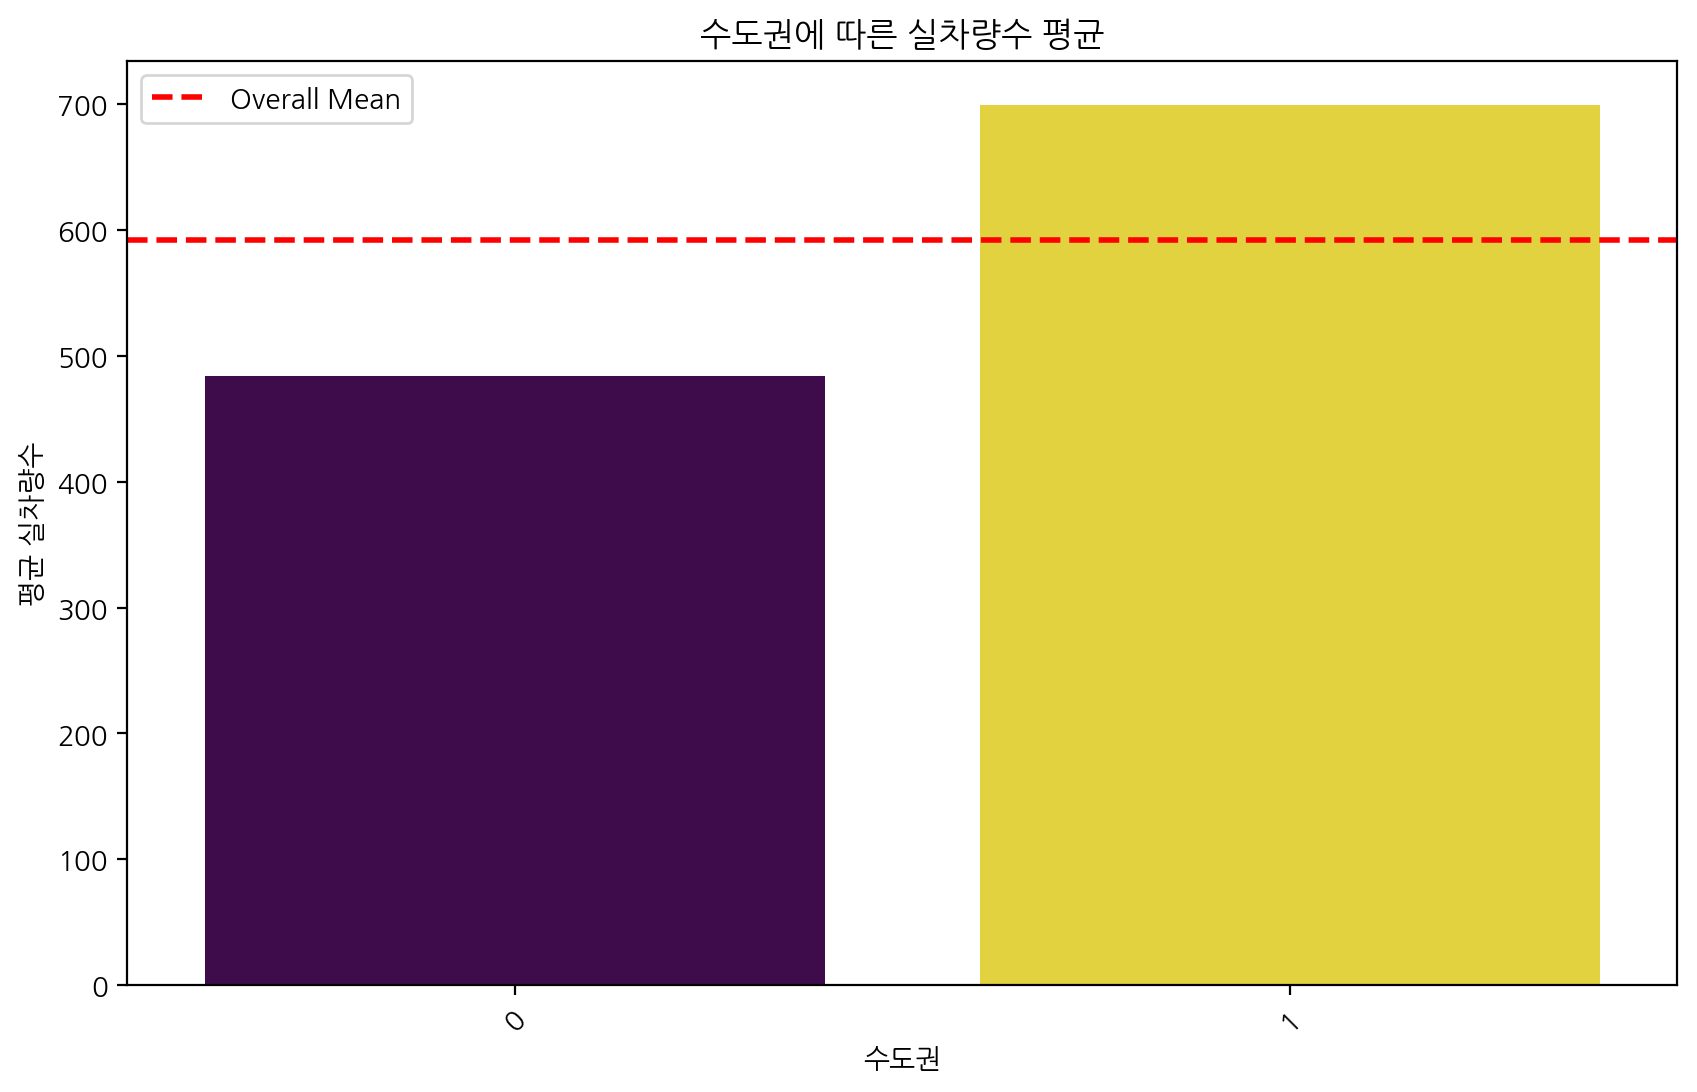

In [322]:
plot_bar_with_categorical_variable(data, target_variable='실차량수', categorical_variable='수도권')

In [280]:
# 타겟
target = '실차량수'

# 데이터 분리
x = data.drop(target, axis=1)
y = data.loc[:, target]

In [282]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1)

In [284]:
# Random
param = {'max_depth': range(1, 21)}
random_model = GridSearchCV(RandomForestRegressor(),param, cv=5)
random_model.fit(x_train, y_train)
y_test_pred = random_model.predict(x_test)
print("Best parameters found: ", random_model.best_params_)
print("Best cross-validation score: ", random_model.best_score_)
print('MAE:', mean_absolute_error(y_test, y_test_pred))
print('R2:', r2_score(y_test, y_test_pred))
random_MAE = mean_absolute_error(y_test, y_test_pred)
random_R2 = r2_score(y_test, y_test_pred)

Best parameters found:  {'max_depth': 6}
Best cross-validation score:  0.7581214928342536
MAE: 133.12676949004572
R2: 0.6886248722101642


In [297]:
# 하이퍼파라미터 범위 설정
random_param = {
    'n_estimators': [50, 100, 200],  # 생성할 트리의 수
    'max_depth': [5, 10, 15],  # 최대 깊이
    'min_samples_split': [2, 5, 10],  # 분할을 위한 최소 샘플 수
    'min_samples_leaf': [1, 2, 4]  # 리프 노드에 필요한 최소 샘플 수
}

# GridSearchCV로 모델 생성 및 학습
random_model = GridSearchCV(RandomForestRegressor(), random_param, cv=5)
random_model.fit(x_train, y_train)

# 최적 모델 선택
random_best = random_model.best_estimator_

# 검증 데이터 예측
y_test_pred = random_best.predict(x_test)

# 성능 평가
print("Best parameters found: ", random_model.best_params_)
print("Best cross-validation score: ", random_model.best_score_)
print('MAE:', mean_absolute_error(y_test, y_test_pred))
print('R2:', r2_score(y_test, y_test_pred))
random2_MAE = mean_absolute_error(y_test, y_test_pred)
random2_R2 = r2_score(y_test, y_test_pred)

Best parameters found:  {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Best cross-validation score:  0.7617637930798467
MAE: 133.4028705500064
R2: 0.6859198372177904


In [285]:
# XGBRegressor
# 선언하기
xgb_model = XGBRegressor()

# 학습하기
xgb_model.fit(x_train, y_train)

# 예측하기
y_pred = xgb_model.predict(x_test)

# 평가하기
print('MAE: ', mean_absolute_error(y_test, y_pred).round(4))
print('R2_Score: ', r2_score(y_test, y_pred))
xgb_MAE = mean_absolute_error(y_test, y_pred)
xgb_R2 = r2_score(y_test, y_pred)

MAE:  122.5746
R2_Score:  0.695333259939726


In [ ]:
# 예측하기
predicted = model4.predict(data)

# 확인
print(predicted)

- 아파트 기본 정보에 예측한 차량수를 붙여 마무리합니다.

In [ ]:
# 데이터 셋 두개로 나누기
vars = ['단지코드', '단지명', '총세대수', '지역', ]
result = new_data[vars].copy()
result = result.drop_duplicates()
result.reset_index(drop=True, inplace=True)

# 예측 결과 추가
result['예상차량수'] = predicted.round(1).astype(int)

# 확인
result